<a href="https://colab.research.google.com/github/gulmert89/projects/blob/main/facial_sentiment_analysis/last_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graduation Project: Image Processing with Convolutional Neural Networks

Images of happy, shocked & sad faces will be analysed by Convolutional Neural Networks.<br>When satisfactory amount of accuracy is achieved, we are going to save that particular model and use it on our camera.

---
# 1\. Introduction

## 1.1 Importing Files & Modules

In [1]:
# from google.colab import drive
# drive.mount("/content/drive/")
# %cd "/content/drive/My Drive/Colab Notebooks/Facial sentiment analysis"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2, requests, time
from zipfile import ZipFile
import datetime, os, io
import matplotlib.pyplot as plt

## 1.2 Getting the dataset ready

In [3]:
shock_zip = ZipFile(io.BytesIO(requests.get("https://github.com/gulmert89/projects/blob/main/facial_sentiment_analysis/datasets/shock.zip?raw=true").content), "r")
happy_zip = ZipFile(io.BytesIO(requests.get("https://github.com/gulmert89/projects/blob/main/facial_sentiment_analysis/datasets/happy.zip?raw=true").content), "r")
sad_zip = ZipFile(io.BytesIO(requests.get("https://github.com/gulmert89/projects/blob/main/facial_sentiment_analysis/datasets/sad.zip?raw=true").content), "r")
neutral_zip = ZipFile(io.BytesIO(requests.get("https://github.com/gulmert89/projects/blob/main/facial_sentiment_analysis/datasets/neutral.zip?raw=true").content), "r")

In [4]:
shock_img = []
happy_img = []
sad_img = []
neutral_img = []
for var_zip, var_img in zip((shock_zip, happy_zip, sad_zip, neutral_zip), 
                            (shock_img, happy_img, sad_img, neutral_img)):
    for img_name in var_zip.namelist():
        byte_data = var_zip.read(img_name)
        img = io.BytesIO(byte_data)
        img = np.array(Image.open(img))
        img = cv2.cvtColor(img, code=6) if len(img.shape) == 3 else img        
        img = cv2.resize(img, (64, 64))
        var_img.append(img)
shock_img = np.asarray(shock_img)
happy_img = np.asarray(happy_img)
sad_img = np.asarray(sad_img)
neutral_img = np.asarray(neutral_img)
LENGTH = len(happy_img)

In the "noted" line above, <code>code = 8</code> refers to <code>cv2.COLOR_GRAY2BGR</code> (see the [link](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html)).<br>This conversation is required since there seems to be 8bpp images in the dataset. The rest is in 24bpp (RGB).

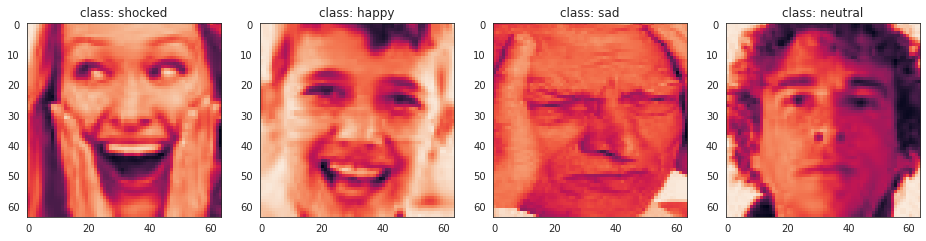

In [5]:
# 3 random images from each class
sns.set_style(style="white")
plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.title("class: shocked")
plt.imshow(shock_img[np.random.randint(0,LENGTH)])
plt.subplot(1,4,2)
plt.title("class: happy")
plt.imshow(happy_img[np.random.randint(0,LENGTH)])
plt.subplot(1,4,3)
plt.title("class: sad")
plt.imshow(sad_img[np.random.randint(0,LENGTH)])
plt.subplot(1,4,4)
plt.title("class: neutral")
plt.imshow(neutral_img[np.random.randint(0,LENGTH)])
plt.show()

***
## 1.3 Train & Test Set

In [6]:
X_train = np.concatenate([neutral_img, sad_img, shock_img, happy_img], axis=0)
y_train = np.array([0]*LENGTH + [1]*LENGTH + [2]*LENGTH + [3]*LENGTH)

# 20% of the pictures will be chosen for the test set
# first we get the random indices:
random_num_sad = np.random.choice(range(0, LENGTH), LENGTH//5, replace=False)
random_num_shock = np.random.choice(range(LENGTH, LENGTH*2), LENGTH//5, replace=False)
random_num_happy = np.random.choice(range(LENGTH*2, LENGTH*3), LENGTH//5, replace=False)
random_num_neutral = np.random.choice(range(LENGTH*3, LENGTH*4), LENGTH//5, replace=False)
random_indices = np.concatenate([random_num_sad,
                                 random_num_shock,
                                 random_num_happy, 
                                 random_num_neutral])
# test set is ready:
X_test = X_train[random_indices]
y_test = y_train[random_indices]
# let's remove the selected pictures from the train set:
X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)

# Do not forget to shuffle the set:
def shuffle_set():
    """To make sure the shuffle is the same for 
    both dependent and independent variables"""
    random_state = np.random.get_state()
    np.random.shuffle(X_train)
    np.random.shuffle(X_test)
    # we keep the random state and pass it to the next step:
    np.random.set_state(random_state)
    np.random.shuffle(y_train)
    np.random.shuffle(y_test)
shuffle_set()

# ...and we dispose of these temporary tools:
del random_num_sad, random_num_shock, random_num_happy, \
    random_indices, shuffle_set, LENGTH

# 2\. Creating The Model

## 2.1 Shape of The Dataset

In [7]:
from keras import models, layers
from keras.utils import to_categorical

In [8]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
X_train = np.expand_dims((X_train / 255.0), axis=3)
X_test = np.expand_dims((X_test / 255.0), axis=3)

# DON'T FORGET TO WRITE ABOUT THE BUG
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
print("---Shape of the train set---\nX_train:", X_train.shape, 
      "\ny_train:", y_train.shape)
print("\n---Shape of the test set---\nX_test:", X_test.shape, 
      "\ny_test:", y_test.shape)

---Shape of the train set---
X_train: (19968, 64, 64, 1) 
y_train: (19968, 4)

---Shape of the test set---
X_test: (4988, 64, 64, 1) 
y_test: (4988, 4)


## 2.2 Neural Network Models

### 2.2.0 TensorBoard Configuration & Monitoring

Here we prepare the TensorBoard configuration to monitor the model's performance below. After creating the model, we will refer to TensorBoard API.

Self reminders:
* To view open TensorBoard instances: <code>tb_notebook.list()</code>

* To kill the current TensorBoard process: <code>!kill #</code> (#:pid number)

* To control TensorBoard display: <code>tb_notebook.display(port=None, height=1000)</code> 
If no port is provided, the most recently launched TensorBoard is used.

In [82]:
from keras.callbacks import TensorBoard
from tensorboard import notebook as tb_notebook

In [83]:
# Load the TensorBoard notebook extension:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### \>>> TensorBoard

In [ ]:
# To run the TensorBoard:
%tensorboard --logdir my_log_dir

## 2.3 Training Our Model

In [11]:
from math import ceil
from keras.optimizers import Adam, schedules
from keras.callbacks import ModelCheckpoint, EarlyStopping
os.mkdir("checkpoint")

In [88]:
def conv_layer(neurons):
    model.add(layers.Conv2D(filters=neurons, 
                            padding="same", 
                            kernel_size=(5, 5)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.50))
def dense_layer(neurons):
    model.add(layers.Dense(neurons))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.50))

In [ ]:
# CONSTANT VARIABLES
# for the model itself:
EPOCH = 250
BATCH_SIZE = 32
VAL_SPLIT = 0.20    # validation_split
STEPS_PER_EPOCH = ceil((X_train.shape[0]  * (1-VAL_SPLIT)) / BATCH_SIZE)
# for the Learning Rate scheduler:
DECAY_STEPS = STEPS_PER_EPOCH * 24
DECAY_RATE = 0.90
# for the early stopping configuration:
EPOCH_LIMIT = 100
VAL_LOSS_BASELINE = None

##################################
MODEL_NAME = f"NewModel-6-DS{DECAY_STEPS}-DR{DECAY_RATE}\
               -E{EPOCH}-EL{EPOCH_LIMIT}-VS{VAL_SPLIT}"
##################################

model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        padding="same", 
                        kernel_size=(5, 5),
                        input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.50))

conv_layer(32)
conv_layer(64)
conv_layer(128)
conv_layer(128)

model.add(layers.Flatten())
dense_layer(16)

model.add(layers.Dense(4, 
                       activation="softmax", 
                       name="Output_Layer"))

model.summary()

# TensorBoard configuration:
my_log_dir = os.path.join("my_log_dir", MODEL_NAME
             #datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"+"(final)")
             )
tensorboard_callbacks = TensorBoard(log_dir=my_log_dir, 
                                    histogram_freq=1)

# ModelCheckpoint configuration:
checkpoint_filepath = "checkpoint/best_model.h5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=False,
                                            monitor="val_loss",
                                            mode="min",
                                            save_best_only=True, 
                                            save_freq="epoch",
                                            )

# EarlyStopping configuration:
earlystopping_callback = EarlyStopping(monitor="val_loss",
                                       patience=EPOCH_LIMIT, 
                                       verbose=0,
                                       mode="min", 
                                       baseline=VAL_LOSS_BASELINE, 
                                       restore_best_weights=True
                                       )

# learning_rate schedule configuration:
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=1e-3, 
                                         decay_steps=DECAY_STEPS, 
                                         decay_rate=DECAY_RATE)
opt = Adam(learning_rate=lr_schedule)

model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_history = model.fit(X_train, y_train, 
                          batch_size=BATCH_SIZE,
                          epochs=EPOCH,
                          verbose=0,
                          validation_split=VAL_SPLIT,
                          callbacks = [tensorboard_callbacks, 
                                       model_checkpoint_callback, 
                                       earlystopping_callback]
                          )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 64, 64, 32)        832       
_________________________________________________________________
batch_normalization_42 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_42 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 32)       

In [12]:
model.save(MODEL_NAME + ".h5")
model.evaluate(X_test, y_test, batch_size=8)

624/624 [==============================] - 2s 3ms/step - loss: 0.4015 - accuracy: 0.8561


[0.40150097012519836, 0.8560545444488525]

In [ ]:
# !zip my_log_dir.zip my_log_dir/model-8-LastTRY_MaxPooling -r